## Generates a file called excised_lx.txt which contains the 15% R_500 core-excised luminosities of Box2, computed using the no-background images

In [47]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from astropy.io import fits
from pathlib import Path
from os.path import expanduser
from useful_functions.plotter import plot, loglogplot

In this notebook, we're going to recompute the luminosities from the xspec code that Lorenzo sent us, then write functions for core-excision. The output of this notebook will be the following:

1. For the N clusters, there will be an L500_obs, L500_ex,obs. (2N data points)
2. We will generate a plot of L500_true vs. L500_obs (probably won't go in paper, but just to verify L values)

From Lorenzo:

I mean, the fact that we add the background does not change the luminosity of the cluster, which is still the one provided by Klaus. The presence of the background just decreases our ability to properly estimate the luminosity (which is one of the problems with observations); naively if you know perfectly the background (e.g. you take the background map that was added to the erosita image) you perfectly recover the Lx from Klaus.

So, if you just need to know the intrinsic Lx of your cluster we can use the values from Klaus. **For the excised Lx you can use the erosita images without the background that I guess Michelle can create in a similar way as done with the ones including the background.**

Instead if you want to simulate the same limitations that will have the observers we need to go though xspec I think. You first determine the background-subtracted count rate and then you use the script that I sent you. 

**Since we want to simulate what the observers will see, we should generate our own Lx values and then core-excise them here.**

Steps:

- count the number of photons in the region of interest 
- estimate the cluster temperature (maybe from an M-T relation)
- varying the norm of apec model in XSPEC until the count rate match the value of your cluster 
- print out the corresponding flux and convert into a Lx

Question:

What is the most fair way to do these calculations? We know the cluster temperatures from Magneticum, but a real observer wouldn't know this, so what is the most fair way to truly get observer luminosities?

In shell you just need to run 

xspec - lumin.tcl 

after having initialized heasoft in the shell. In principle it can be translated into a python code but I never did. 

Before running the script you need to create a file "cluster.par" which include almost all the parameters required by the script: column density, cluster temperature, cluster metallicity, redshift, count rate, exposure. E.g. 

echo -n 5E20 3.6 0.3 0.12 0.35 1600 >! cluster.par 

For the hydrogen column density and exposure you should used the values used to run the simulation.

**Pending: Michelle send these two pieces of information (2000 seconds), Michelle sends no-background images, Michelle/Lorenzo suggest what temperature to use, Klaus responds with necessary data files**

In [2]:
#in the mean time, we can write our functions to perform the core-excision
#we load in the fits files and have the cluster information available
#need the radii in pixels
#then we count up all within the radii
#we cound up the amount within 15% of the radii
#simple math
data_dir = Path('../data')
home_dir = Path(expanduser('~'))

fig_dir = Path('../figs/')
chandra_dir = home_dir / 'magneticum_chandra'
erosita_no_bg_dir = home_dir / 'magneticum_no_bg'

cluster_directory = chandra_dir

In [3]:
magneticum_data = np.load(cluster_directory / 'clusterList.npy')
# make this into a pandas data frame
magneticum_data = pd.DataFrame(data=magneticum_data, columns=magneticum_data.dtype.names)
magneticum_data = magneticum_data.set_index('id')
Nclusters = len(magneticum_data.index)

In [4]:
def distance(x1, x2):
    return np.sqrt((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2)

In [7]:
#make an array that is 384 x 384, and each element contains the 4 corners in the cell

#so we say that we are within the radius if part of the pixel is within the radius,
#not if its center is within radius
#TODO: we should see how much things differ when we do this...
img_shape_x, img_shape_y = fits.open(cluster_directory / '922603.fits')[0].data.shape
center = np.array([img_shape_x, img_shape_y]) / 2.
cell_dists = np.ndarray((img_shape_x, img_shape_y))
for i in range(0, img_shape_x):
    for j in range(0, img_shape_y):
#        #cell_dists[i,j] = distance(center, [i,j])
        cell_dists[i,j] = np.min([distance(center,[i,j]), distance(center,[i+1,j]), 
                                  distance(center,[i,j+1]), distance(center,[i+1,j+1])])

In [8]:
def core_excised_Lx(cluster_id, excise_rad_frac):
    dat = fits.open(cluster_directory / ('%d.fits' % cluster_id))[0].data
    r500 = magneticum_data['R500_pixel'].loc[cluster_id]
    total_mask = (cell_dists <= r500)
    excise_mask = (cell_dists <= excise_rad_frac * r500)
    Ntot = np.sum(dat[total_mask])
    Ncore = np.sum(dat[excise_mask])
    #print((Ntot-Ncore)/Ntot)
    return (Ntot-Ncore)/Ntot * magneticum_data['Lx_ergs'].loc[cluster_id]

def core_excised_counts(cluster_id, excise_rad_frac):
    dat = fits.open(cluster_directory / ('%d.fits' % cluster_id))[0].data
    r500 = magneticum_data['R500_pixel'].loc[cluster_id]
    total_mask = (cell_dists <= r500)
    excise_mask = (cell_dists <= excise_rad_frac * r500)
    Ntot = np.sum(dat[total_mask])
    Ncore = np.sum(dat[excise_mask])
    return(Ntot-Ncore)

In [9]:
excised_counts = np.zeros(Nclusters)
for i,cluster_id in enumerate(magneticum_data.index.values):
    print(i)
    excised_counts[i] = core_excised_counts(cluster_id, 0.15)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


Text(0.5, 0, '$\\log N_{ex}$')

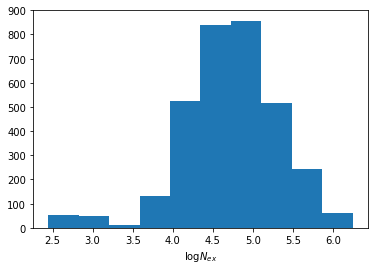

In [10]:
plt.hist(np.log10(excised_counts))
plt.xlabel(r'$\log N_{ex}$')

# much higher for the Chandra data, wonder what is going on down at the low end...

In [9]:
#the dead center is the bottom corner of pixel 192 (counting from 0 as in python.)
#this is same as saying (starting from 1) pixels (192-193) is the center, if pixels are defined from center
#if we want to 

In [12]:
pix_corner_excised_Lx = np.zeros(Nclusters)
for i,cluster_id in enumerate(magneticum_data.index.values):
    if(i % 100 == 0):
        print(i)
    pix_corner_excised_Lx[i] = core_excised_Lx(cluster_id, 0.15)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200


In [14]:
#this is if we want to measure within R500 based on the pixel centers instead of nearest edge
#pix_center_excised_Lx = np.zeros(Nclusters)
#for i,cluster_id in enumerate(magneticum_data.index.values):
#    pix_center_excised_Lx[i] = core_excised_Lx(cluster_id, 0.15)

In [15]:
#plt.hist(np.log10(pix_corner_excised_Lx),alpha=0.5,label='Corner', bins=100)
#plt.hist(np.log10(pix_center_excised_Lx),alpha=0.5,label='Center', bins=100)
#plt.legend()

#looks like the center values are larger, only slightly
#this is because we are more likely to excise an extra ring of pixels if we use the center
#i'll use the center, because it seems more reasonable to me, even though it makes very little difference

In [13]:
#now, we want to save a list of the excised Lx values and the respective cluster ids,
#to be loaded into our main file
output = np.column_stack((magneticum_data.index.values, pix_corner_excised_Lx))
np.savetxt(data_dir / 'chandra_excised_lx.txt',output,fmt='%d %e')

In [44]:
# let's do a comparison between chandra and erosita core-excised
erosita_ex_lx = np.loadtxt(data_dir / 'excised_lx.txt')
chandra_ex_lx = np.loadtxt(data_dir / 'chandra_excised_lx.txt')
print(erosita_ex_lx.shape)
print(chandra_ex_lx.shape)

(2343, 2)
(3292, 2)


In [45]:
msk = np.isin(chandra_ex_lx[:,0], erosita_ex_lx[:,0])
chandra_ex_lx = chandra_ex_lx[msk]
msk = np.isin(erosita_ex_lx[:,0], chandra_ex_lx[:,0])
erosita_ex_lx = erosita_ex_lx[msk]
chandra_ex_lx = chandra_ex_lx[np.argsort(erosita_ex_lx[:,0])]
erosita_ex_lx = erosita_ex_lx[np.argsort(erosita_ex_lx[:,0])]
print(erosita_ex_lx.shape)
print(chandra_ex_lx.shape)
for i in range(0, len(chandra_ex_lx)):
    #print(i)
    assert(chandra_ex_lx[i,0] == erosita_ex_lx[i,0])

(2342, 2)
(2342, 2)


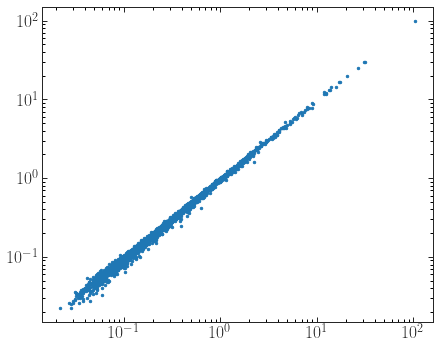

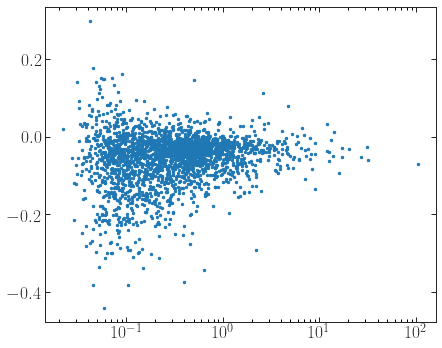

In [49]:
loglogplot()
plt.plot(chandra_ex_lx[:,1],erosita_ex_lx[:,1],'.')

rel_err = (erosita_ex_lx[:,1] - chandra_ex_lx[:,1]) / chandra_ex_lx[:,1]

plot(semilogx=True)
plt.plot(chandra_ex_lx[:,1],rel_err,'.')

# this tells us that the chandra luminosities are basically always larger, and this should be no surprise
# since we have more pixels, we can throw out less light at the boundary

# however, i'm surprised at the percentage-level difference between the two


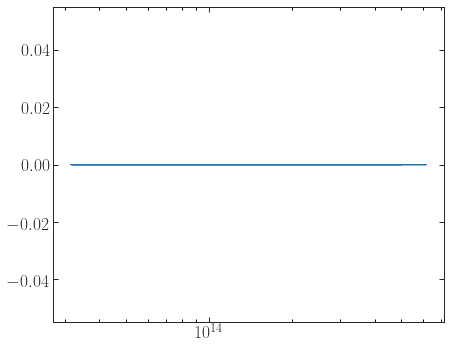

In [54]:
# let's make sure the luminosities from the raw data files are the same though, just to confirm that the only effect
# is simply due to the core excision process
erosita_data = np.load(data_dir / 'clusterList.npy')
chandra_data = np.load(cluster_directory / 'clusterList.npy')

msk = np.isin(chandra_data['id'], erosita_data['id'])
chandra_data = chandra_data[msk]
msk = np.isin(erosita_data['id'], chandra_data['id'])
erosita_data = erosita_data[msk]
chandra_data = chandra_data[np.argsort(erosita_data['id'])]
erosita_data = erosita_data[np.argsort(erosita_data['id'])]

rel_err = (erosita_data['M500_msolh'] - chandra_data['M500_msolh']) / chandra_data['M500_msolh']
plot(semilogx=True)
plt.plot(chandra_data['M500_msolh'], rel_err)

# this is good, they're the exact same
# hence, the only cause for discrepancy in the values of the core-excised luminosities is the excision process